In [1]:
import torch
from torchvision import datasets
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [3]:
data = datasets.EMNIST(root='data', split='letters', download=True)

100%|██████████| 562M/562M [00:39<00:00, 14.4MB/s]


In [47]:
X = data.data
y = data.targets

X.shape,y.shape

(torch.Size([124800, 28, 28]), torch.Size([124800]))

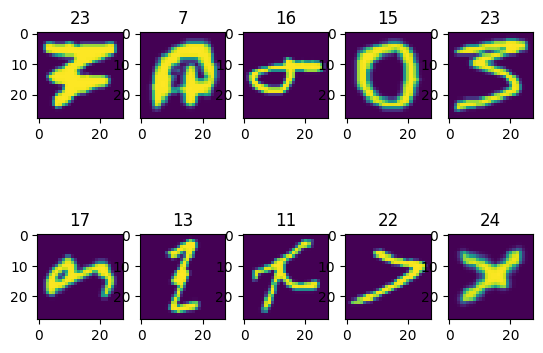

In [48]:
for i, (image, label) in zip(range(1, 11), data):
        plt.subplot(2, 5, i)
        plt.imshow(X=image)
        plt.title(label=label)


### Only considering the 5 vowel letters for multi-class classification

Just so that the session doesn't crash taking only 1500 samples from each class since there are about 28000 total which is a little more

In [49]:
check = torch.where(y == 1)
check

(tensor([    29,     32,     35,  ..., 124776, 124781, 124784]),)

In [50]:
selected_classes = [1, 5, 9, 15, 21]  # These represent vowels: a, e, i, o, u
samples_per_class = 1500

selected_indices = []

for cls in selected_classes:
    class_indices = torch.where(y == cls)[0]

    shuffled_indices = torch.randperm(class_indices.shape[0])

    chosen_indices = class_indices[shuffled_indices[:samples_per_class]]

    selected_indices.append(chosen_indices)

final_indices = torch.cat(selected_indices, dim=0)

X = X[final_indices]
y = y[final_indices]

print("Selected X shape:", X.shape)
print("Selected y shape:", y.shape)

Selected X shape: torch.Size([7500, 28, 28])
Selected y shape: torch.Size([7500])


In [51]:
indices = torch.randperm(X.shape[0])
X = X[indices]
y = y[indices]

total_pixels = X.shape[1] * X.shape[2]

X = X.view(-1,total_pixels)
X = X / 255.0
X.shape

torch.Size([7500, 784])

In [52]:
train_size = int(0.8 * X.shape[0])
test_size = X.shape[0] - train_size

X_train = X[:train_size]
y_train = y[:train_size]

X_test = X[train_size:]
y_test = y[train_size:]

In [53]:
def initialize_w_b(input_dim):
  w = torch.randn((input_dim, 5), requires_grad=True) * 0.01
  b = torch.ones(5, requires_grad=True)

  return w, b

In [54]:
def compare_grad(grad1, grad2):
  print(torch.max(torch.abs(grad1 - grad2)))

In [55]:
label_mapping = {1: 0, 5: 1, 9: 2, 15: 3, 21: 4}
y_train = torch.tensor([label_mapping[label.item()] for label in y_train])
y_test = torch.tensor([label_mapping[label.item()] for label in y_test])

In [56]:
s = torch.tensor(
    [[1,2,3],[4,5,6],[7,8,9]]
)
print(s)
max = s.sum(dim=1, keepdim=True)
print(max)

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])
tensor([[ 6],
        [15],
        [24]])


In [57]:
print(logit.shape)
print(logit_max.shape)
print(logit_exp_sum_inv.shape)
print(probs.shape)
print(L)
print(dL_dlogprobs.shape)

torch.Size([6000, 5])
torch.Size([6000, 1])
torch.Size([6000, 1])
torch.Size([6000, 5])
tensor(1.5833, grad_fn=<NegBackward0>)
torch.Size([6000, 5])


In [58]:
import torch.nn.functional as F

In [70]:
W,b = initialize_w_b(total_pixels)
lr = 0.001
loss_list = []

for i in range(1000):
  # forward pass
  logit = X_train @ W + b
  logit_max = logit.max(dim = 1, keepdim = True).values
  logit_new = logit - logit_max
  # Softmax calculation begin here
  logit_exp = logit_new.exp()
  logit_exp_sum = logit_exp.sum(dim = 1, keepdim = True)
  logit_exp_sum_inv = logit_exp_sum ** (-1)
  probs = logit_exp * logit_exp_sum_inv
  # Softmax ends here
  # Cross entropy calculation begins here
  log_probs = torch.log(probs)
  L = - log_probs[torch.arange(X_train.shape[0]), y_train].mean()

  loss_list.append(L.item())

  step_variables_list = [
      W,
      b,
      logit,
      logit_max,
      logit_new,
      logit_exp,
      logit_exp_sum,
      logit_exp_sum_inv,
      probs,
      log_probs
  ]
  # for item in step_variables_list:
  #   item.retain_grad()
  # L.backward()

  # Manual backpropagation
  dL_dlogprobs = torch.zeros_like(log_probs)
  dL_dlogprobs[torch.arange(X_train.shape[0]), y_train] = -1 / X_train.shape[0]

  dL_dprobs = (probs)**(-1) * dL_dlogprobs

  dL_dlogit_exp_sum_inv = (logit_exp * dL_dprobs).sum(1, keepdim = True)

  # 1st half of calculation
  dL_dlogit_exp = logit_exp_sum_inv * dL_dprobs

  dL_dlogit_exp_sum = -(logit_exp_sum ** (-2)) * dL_dlogit_exp_sum_inv

  # 2nd half calculation
  dL_dlogit_exp += torch.ones_like(logit_exp) * dL_dlogit_exp_sum

  dL_dlogit_new = logit_new.exp() * dL_dlogit_exp

  dL_dlogit_max = - dL_dlogit_new.sum(1, keepdim = True)

  dL_dlogit = dL_dlogit_new.clone()

  # This was done at first but gave correct answer although not the correct way of implementation
  # dL_dlogit += torch.ones_like(logit) * dL_dlogit_max

  # This is using the pre-defined one-hot encoding
  # dL_dlogit += F.one_hot(logit.max(1).indices, 5) * dL_dlogit_max

  # Self-implementation of the one-hot
  mask = (logit == logit.max(1, keepdim=True).values)
  mask = mask.int()
  dL_dlogit += mask * dL_dlogit_max

  dL_dW = X_train.T @ dL_dlogit
  dL_db = dL_dlogit.sum(0)

  # Making updates
  with torch.no_grad():
    W -= lr * dL_dW
    b -= lr * dL_db

In [71]:
# print(torch.allclose(log_probs.grad, dL_dlogprobs))
# compare_grad(log_probs.grad, dL_dlogprobs)
# print("..........................................")
# print(torch.allclose(probs.grad, dL_dprobs))
# compare_grad(probs.grad, dL_dprobs)
# print("..........................................")
# print(torch.allclose(logit_exp_sum_inv.grad, dL_dlogit_exp_sum_inv))
# compare_grad(logit_exp_sum_inv.grad, dL_dlogit_exp_sum_inv)
# print("..........................................")
# print(torch.allclose(logit_exp_sum.grad, dL_dlogit_exp_sum))
# compare_grad(logit_exp_sum.grad, dL_dlogit_exp_sum)
# print("..........................................")
# print(torch.allclose(logit_exp.grad, dL_dlogit_exp))
# compare_grad(logit_exp.grad, dL_dlogit_exp)
# print("..........................................")
# print(torch.allclose(logit_new.grad, dL_dlogit_new))
# compare_grad(logit_new.grad, dL_dlogit_new)
# print("..........................................")
# print(torch.allclose(logit_max.grad, dL_dlogit_max))
# compare_grad(logit_max.grad, dL_dlogit_max)
# print("..........................................")
# print(torch.allclose(logit.grad, dL_dlogit))
# compare_grad(logit.grad, dL_dlogit)
# print("..........................................")
# print(torch.allclose(W.grad, dL_dW))
# compare_grad(W.grad, dL_dW)
# print("..........................................")
# print(torch.allclose(b.grad, dL_db))
# compare_grad(b.grad, dL_db)

In [72]:
print(loss_list)

[1.6066882610321045, 1.6041553020477295, 1.6016396284103394, 1.5991407632827759, 1.5966588258743286, 1.5941932201385498, 1.5917437076568604, 1.5893096923828125, 1.5868914127349854, 1.5844879150390625, 1.5820993185043335, 1.5797252655029297, 1.5773652791976929, 1.575019359588623, 1.572687029838562, 1.5703681707382202, 1.5680625438690186, 1.565769910812378, 1.563489556312561, 1.561221957206726, 1.5589667558670044, 1.5567233562469482, 1.5544918775558472, 1.5522719621658325, 1.5500633716583252, 1.547865867614746, 1.5456796884536743, 1.5435041189193726, 1.5413391590118408, 1.5391846895217896, 1.5370407104492188, 1.5349063873291016, 1.5327821969985962, 1.530668020248413, 1.5285630226135254, 1.5264678001403809, 1.5243818759918213, 1.5223050117492676, 1.5202370882034302, 1.5181783437728882, 1.5161283016204834, 1.5140869617462158, 1.5120537281036377, 1.5100290775299072, 1.5080128908157349, 1.5060045719146729, 1.5040045976638794, 1.5020122528076172, 1.5000276565551758, 1.4980509281158447, 1.4960

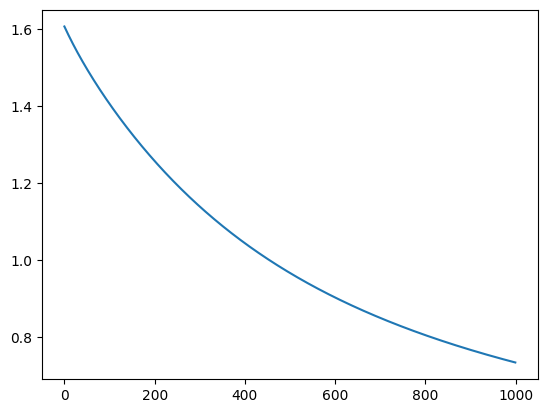

In [73]:
plt.plot(loss_list)

In [74]:
# Inference
y_preds = X_test @ W + b

# Softmax application
logit_max = y_preds.max(dim=1, keepdim=True).values
logit_new = y_preds - logit_max
logit_exp = logit_new.exp()
logit_exp_sum = logit_exp.sum(dim=1, keepdim=True)
logit_exp_sum_inv = logit_exp_sum ** (-1)
probs = logit_exp * logit_exp_sum_inv

# Predicted class = argmax of probabilities
pred_labels = probs.argmax(dim=1)
print(pred_labels[:10])
print(y_test[:10])

correct_predictions = (y_test == pred_labels).sum()
total_samples = y_test.shape[0]
accuracy = correct_predictions.item() / total_samples

print("Correct Predictions:", correct_predictions.item(),"out of", total_samples)
print(f"Accuracy: {accuracy:.4f}")

tensor([1, 0, 1, 4, 0, 2, 4, 1, 4, 0])
tensor([1, 0, 1, 4, 2, 2, 4, 1, 4, 0])
Correct Predictions: 1272 out of 1500
Accuracy: 0.8480


In [75]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 885.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [76]:
from torchmetrics import ConfusionMatrix, Precision, Recall, F1Score

In [77]:
precision = Precision(task="multiclass", num_classes=5)
recall = Recall(task="multiclass", num_classes=5)
f1 = F1Score(task="multiclass", num_classes=5)
confmat = ConfusionMatrix(task="multiclass", num_classes=5)

print("Precision :: ",precision(pred_labels, y_test))
print("Recall :: ",recall(pred_labels, y_test))
print("f1 score :: ",f1(pred_labels, y_test))
print(confmat(pred_labels, y_test))

Precision ::  tensor(0.8480)
Recall ::  tensor(0.8480)
f1 score ::  tensor(0.8480)
tensor([[222,  23,   9,  28,  15],
        [ 11, 269,   3,   8,   3],
        [  5,   9, 270,   1,   2],
        [ 17,   9,   5, 272,   8],
        [ 37,   4,   4,  27, 239]])
